<a href="https://colab.research.google.com/github/Qhwelah/NeuralBlock-NeuralNetPredictor/blob/main/NeuralNetPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Prepping for the Models**

In [86]:
# !pip3 uninstall gdown -y && pip3 install gdown
import gdown

url = "https://drive.google.com/uc?id=1UPXnC2oy20r4Yesw7lPuDRHlsoR0l0DV"
output = "data.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1UPXnC2oy20r4Yesw7lPuDRHlsoR0l0DV
To: /content/data.csv
100%|██████████| 8.96M/8.96M [00:00<00:00, 209MB/s]


'data.csv'

In [87]:
## import the data
import pandas as pd

df = pd.read_csv("data.csv")

print(df)

      xRot   yRot                block_1  block_1_dist                block_2  \
0    81.45  26.98   minecraft:oak_leaves             6   minecraft:oak_planks   
1    59.47   2.02   minecraft:oak_planks             4        minecraft:water   
2   -58.81   3.46         minecraft:dirt           159        minecraft:stone   
3    61.45  36.54   minecraft:oak_leaves            40        minecraft:stone   
4   -44.43  84.42  minecraft:grass_block            56        minecraft:stone   
..     ...    ...                    ...           ...                    ...   
115  23.38  11.33   minecraft:oak_planks            11        minecraft:water   
116   1.92  50.17         minecraft:dirt            72   minecraft:oak_planks   
117 -64.33  83.93   minecraft:oak_planks            21  minecraft:grass_block   
118  -1.77   5.55        minecraft:stone           146        minecraft:stone   
119  11.65  76.97          minecraft:air           113   minecraft:oak_planks   

     block_2_dist          

In [88]:
## Getting all values of non-numeric types only
df.info()
non_numeric_values = df.select_dtypes(exclude=["float", "int"])
# print(non_numeric_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Columns: 7202 entries, xRot to block_3600_dist
dtypes: float64(2), int64(3600), object(3600)
memory usage: 6.6+ MB


In [89]:
## Mapping all non-numeric data values to some numeric values

# parameters:
columns_to_check_for_unique_values = 20

# internal values:
block_mapping_conversions = []

print("Event log for block conversion pushes: ")
j = 1  # iterator for determining which block column to use
while(j < columns_to_check_for_unique_values+1):
  block_column = f"block_{j}"
  block_mapping = df[block_column].factorize()
  # print(f"Conversion values for {block_column}: ")
  # print(block_mapping)
  # print()
  i = 0  # iterator for checking within a single column's conversion mapping
  while i < len(block_mapping[0]):
    mapped_index = block_mapping[0][i]
    if mapped_index == -1:
      i += 1
      continue
    new_conversion = block_mapping[1][mapped_index]
    if new_conversion not in block_mapping_conversions:
      block_mapping_conversions.append(new_conversion)
      print(f"pushing {new_conversion} to values at index {len(block_mapping_conversions)-1}")
    i += 1
  j += 1

block_mapping_conversions.append('unknown')
print(f"pushing unknown to values at index {len(block_mapping_conversions)-1}")

print()
print("Final conversion values: ")
print(block_mapping_conversions)

Event log for block conversion pushes: 
pushing minecraft:oak_leaves to values at index 0
pushing minecraft:oak_planks to values at index 1
pushing minecraft:dirt to values at index 2
pushing minecraft:grass_block to values at index 3
pushing minecraft:air to values at index 4
pushing minecraft:stone to values at index 5
pushing minecraft:water to values at index 6
pushing minecraft:oak_log to values at index 7
pushing unknown to values at index 8

Final conversion values: 
['minecraft:oak_leaves', 'minecraft:oak_planks', 'minecraft:dirt', 'minecraft:grass_block', 'minecraft:air', 'minecraft:stone', 'minecraft:water', 'minecraft:oak_log', 'unknown']


In [90]:
## Converting actual data values in the dataframe to numbers using block mapping
def convertBlock(val):
  for i in range(len(block_mapping_conversions)):
    if val == block_mapping_conversions[i]:
      return i
  return -1

block_columns = [col for col in df.columns if col.startswith("block_") and not col.endswith("_dist")]
# print(block_columns)
df_numerical = df.copy() # make a backup copy of the dataframe to reference later
for col in block_columns:
  df_numerical[col] = df_numerical[col].apply(convertBlock)

print()
print(df_numerical) # the numerized dataframe


      xRot   yRot  block_1  block_1_dist  block_2  block_2_dist  block_3  \
0    81.45  26.98        0             6        1            94        7   
1    59.47   2.02        1             4        6             9        4   
2   -58.81   3.46        2           159        5            75        4   
3    61.45  36.54        0            40        5            21        4   
4   -44.43  84.42        3            56        5            41        5   
..     ...    ...      ...           ...      ...           ...      ...   
115  23.38  11.33        1            11        6            50        4   
116   1.92  50.17        2            72        1            93        1   
117 -64.33  83.93        1            21        3           110        5   
118  -1.77   5.55        5           146        5           151        5   
119  11.65  76.97        4           113        1            18        3   

     block_3_dist  block_4  block_4_dist  ...  block_3596  block_3596_dist  \
0       

**KNN Model Predictions**

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [92]:
distance_columns = [col for col in df_numerical.columns if 'dist' in col]

target_distance_column = 'block_5_dist'

for col in distance_columns:
    if col != target_distance_column:
        df_numerical[col] = (df_numerical[col] - df_numerical[target_distance_column]).abs()

df_numerical = df_numerical.drop(columns=[target_distance_column])

In [93]:
target_block = 'block_5'

X = df_numerical.drop(columns=[target_block])
y = df_numerical[target_block]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [94]:
knn = KNeighborsClassifier(n_neighbors=26, weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=26, weights='distance')

In [95]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"KNN model accuracy: {accuracy:.2f}")

KNN model accuracy: 0.38


**Neural Network via TensorFlow Predictions**

In [96]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Data Masking and Test/Train Splits

In [97]:
def mask_entries(X, mask_candidate_column_indices, missing_val=9, missing_rate=0.1):
    print("started")
    X_masked = X.copy()
    mask = pd.DataFrame(False, index=X.index, columns=X.columns)
    print("copies made")

    # Randomly selects (missing_rate)% of the data columns provided in mask_candidate_column_indices
    #  to "mask" (swap out for the missing_val) for each individual data row.
    for i in range(X.shape[0]):  # for each row
        num_mask = max(1, int(len(mask_candidate_column_indices) * missing_rate))
        mask_indices = np.random.choice(mask_candidate_column_indices, num_mask, replace=False)
        mask_columns = X.columns[mask_indices]
        # print(mask_indices)
        X_masked.loc[i, mask_columns] = missing_val
        mask.loc[i, mask_columns] = True  # track what was masked

    print("Exited masking loop")
    return X_masked, mask

In [98]:
## Parameters --- ##
# Percentage of data to mask and ask the model to fill in (0-1):
missing_rate = 0.1
# The location in the conversion list where the 'unknown' conversion was appended
missing_val = len(block_mapping_conversions)-1
## -------------- ##

# Data prepping
X_NN = df_numerical.copy()
print(X_NN.shape)

# Train/Test splits
from sklearn.model_selection import train_test_split
X_NN_train, X_NN_test = train_test_split(X_NN, test_size=0.2, random_state=42)

# Save current indices from overall list and reset the train/test indices each starting at index 0
train_indices = X_NN_train.index.copy()
test_indices = X_NN_test.index.copy()
X_NN_train = X_NN_train.reset_index(drop=True)
X_NN_test = X_NN_test.reset_index(drop=True)

# Masking data in each row for prediction later
masking_candidates = [col for col in df_numerical.columns if not col.endswith("_dist") and not col.endswith("Rot")]
  # exclude rotation values from masking, as well as distance values. Currently it only subs in fake *block ids*, not distances.
masking_candidate_indices = [df_numerical.columns.get_loc(col) for col in masking_candidates]

X_NN_train_masked, train_mask = mask_entries(X_NN_train, masking_candidate_indices, missing_val, missing_rate)
X_NN_test_masked, test_mask = mask_entries(X_NN_test, masking_candidate_indices, missing_val, missing_rate)

print("Training data:")
print(X_NN_train_masked.shape)

print()
print("Testing data:")
print(X_NN_test_masked.shape)

(120, 7201)
started
copies made
Exited masking loop
started
copies made
Exited masking loop
Training data:
(96, 7201)

Testing data:
(24, 7201)


In [99]:
print("Training data:")
print(X_NN_train_masked)

print()
print("Testing data:")
print(X_NN_test_masked)

Training data:
     xRot   yRot  block_1  block_1_dist  block_2  block_2_dist  block_3  \
0  -63.50  25.09        8            58        8             8        1   
1   22.69  22.52        5            35        5            38        7   
2  -30.97  52.76        4            48        8            40        5   
3  -83.30  15.05        2            51        8            11        5   
4   60.84  11.27        4            93        6            89        8   
..    ...    ...      ...           ...      ...           ...      ...   
91  81.58  28.55        5            19        6             4        1   
92  21.75  81.58        7            55        1            11        1   
93 -41.43  10.16        8            86        5            38        1   
94   2.65   8.53        8            44        0             9        1   
95 -71.45  54.84        1            95        3             2        0   

    block_3_dist  block_4  block_4_dist  ...  block_3596  block_3596_dist  \
0      

TensorFlow Model

In [100]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [101]:
X_train_input = X_NN_train_masked.values  # Masked input
y_train_target = X_NN_train.values        # Original target

X_test_input = X_NN_test_masked.values
y_test_target = X_NN_test.values

# Model building
input_dim = X_train_input.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(2048, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(input_dim, activation='relu')  # output size = input size, activation relu to ensure positive output
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 2048)           │    14,749,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7201)           │     3,694,113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,066,785 (80.36 MB)

 Trainable params: 21,066,785 (80.36 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
# Define the loss function
def masked_mse_loss(y_true, y_pred):
    missing_val = 9.0  # whatever you used during masking

    # Create a mask: 1 if y_true == missing_val, else 0
    mask = tf.cast(tf.equal(y_true, missing_val), dtype=tf.float32)

    # Loss only where mask == 1
    loss = tf.square(y_true - y_pred) * mask

    # Average the loss only over the masked elements
    loss_sum = tf.reduce_sum(loss)
    num_masked = tf.reduce_sum(mask)

    # avoid division by zero
    return tf.cond(num_masked > 0, lambda: loss_sum / num_masked, lambda: tf.constant(0.0))


In [103]:
# compile TensorFlow model
model.compile(optimizer='adam', loss=masked_mse_loss)

In [104]:
# Model Training and Hyperparameters
history = model.fit(
    X_train_input, y_train_target,
    validation_data=(X_test_input, y_test_target),
    epochs=50,
    batch_size=32
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 477ms/step - loss: 213.8961 - val_loss: 77.0132
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - loss: 64.8721 - val_loss: 55.7476
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - loss: 54.5521 - val_loss: 55.7424
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step - loss: 52.0925 - val_loss: 52.2694
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 535ms/step - loss: 46.6626 - val_loss: 48.2000
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - loss: 42.8405 - val_loss: 47.6847
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - loss: 38.2944 - val_loss: 43.5279
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - loss: 35.5049 - val_loss: 42.8834
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - loss: 32.9772 - val_loss: 42.0477
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step - loss: 29.9655 - val_loss: 40.0513
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - loss: 28.0415 - val_loss: 40.3870
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step 

In [105]:
# applying the model to make our predictions
predictions = model.predict(X_test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


In [106]:
# Get the prediction values into a df to analyze
# print(predictions)
predictions_df = pd.DataFrame(predictions, columns=X_NN_test.columns)
print(predictions_df)

    xRot  yRot   block_1  block_1_dist   block_2  block_2_dist  block_3  \
0    0.0   0.0  6.891947      9.966906  1.832385      9.516568      0.0   
1    0.0   0.0  5.244509      7.935826  1.309313      8.027783      0.0   
2    0.0   0.0  5.142097      7.769250  1.408448      7.972327      0.0   
3    0.0   0.0  5.455933      8.457329  1.637509      8.609462      0.0   
4    0.0   0.0  5.767933      8.847560  1.284629      8.545814      0.0   
5    0.0   0.0  6.902079      9.577205  1.783046      9.229426      0.0   
6    0.0   0.0  7.932167     11.817129  1.843844     11.882269      0.0   
7    0.0   0.0  5.537533      7.863121  1.387936      7.874790      0.0   
8    0.0   0.0  8.315626     12.508320  2.155065     11.720694      0.0   
9    0.0   0.0  6.232268      9.170422  1.382449      8.972816      0.0   
10   0.0   0.0  8.247041     11.517239  2.147715     10.918870      0.0   
11   0.0   0.0  8.788035     12.017735  2.579837     11.377140      0.0   
12   0.0   0.0  5.556789 

In [107]:
# Data evaluations

# Get only the masked entries for evaluation
masked_positions = test_mask  # DataFrame with same shape

# Pull ground truth values where we masked
true_values = X_NN_test[masked_positions]

# Pull model predictions where we masked
predicted_values = predictions_df[masked_positions].round()

# print(predicted_values)
# print()
# print(true_values)

In [108]:
# Flatten into 1D arrays for comparison
y_true = true_values.values.flatten()
y_pred = predicted_values.values.flatten()


# Find only where y_true is NOT NaN
valid_mask = ~np.isnan(y_true)
valid_mask &= ~np.isnan(y_pred)

# Apply mask
y_true_valid = y_true[valid_mask].astype(int)
y_pred_valid = y_pred[valid_mask].astype(int)


# Only compare where there was actually a masked entry
correct = (y_true_valid == y_pred_valid).sum()
total = len(y_true)

accuracy = correct / total
print(f"Masked prediction accuracy: {accuracy:.4f}")

Masked prediction accuracy: 0.0035


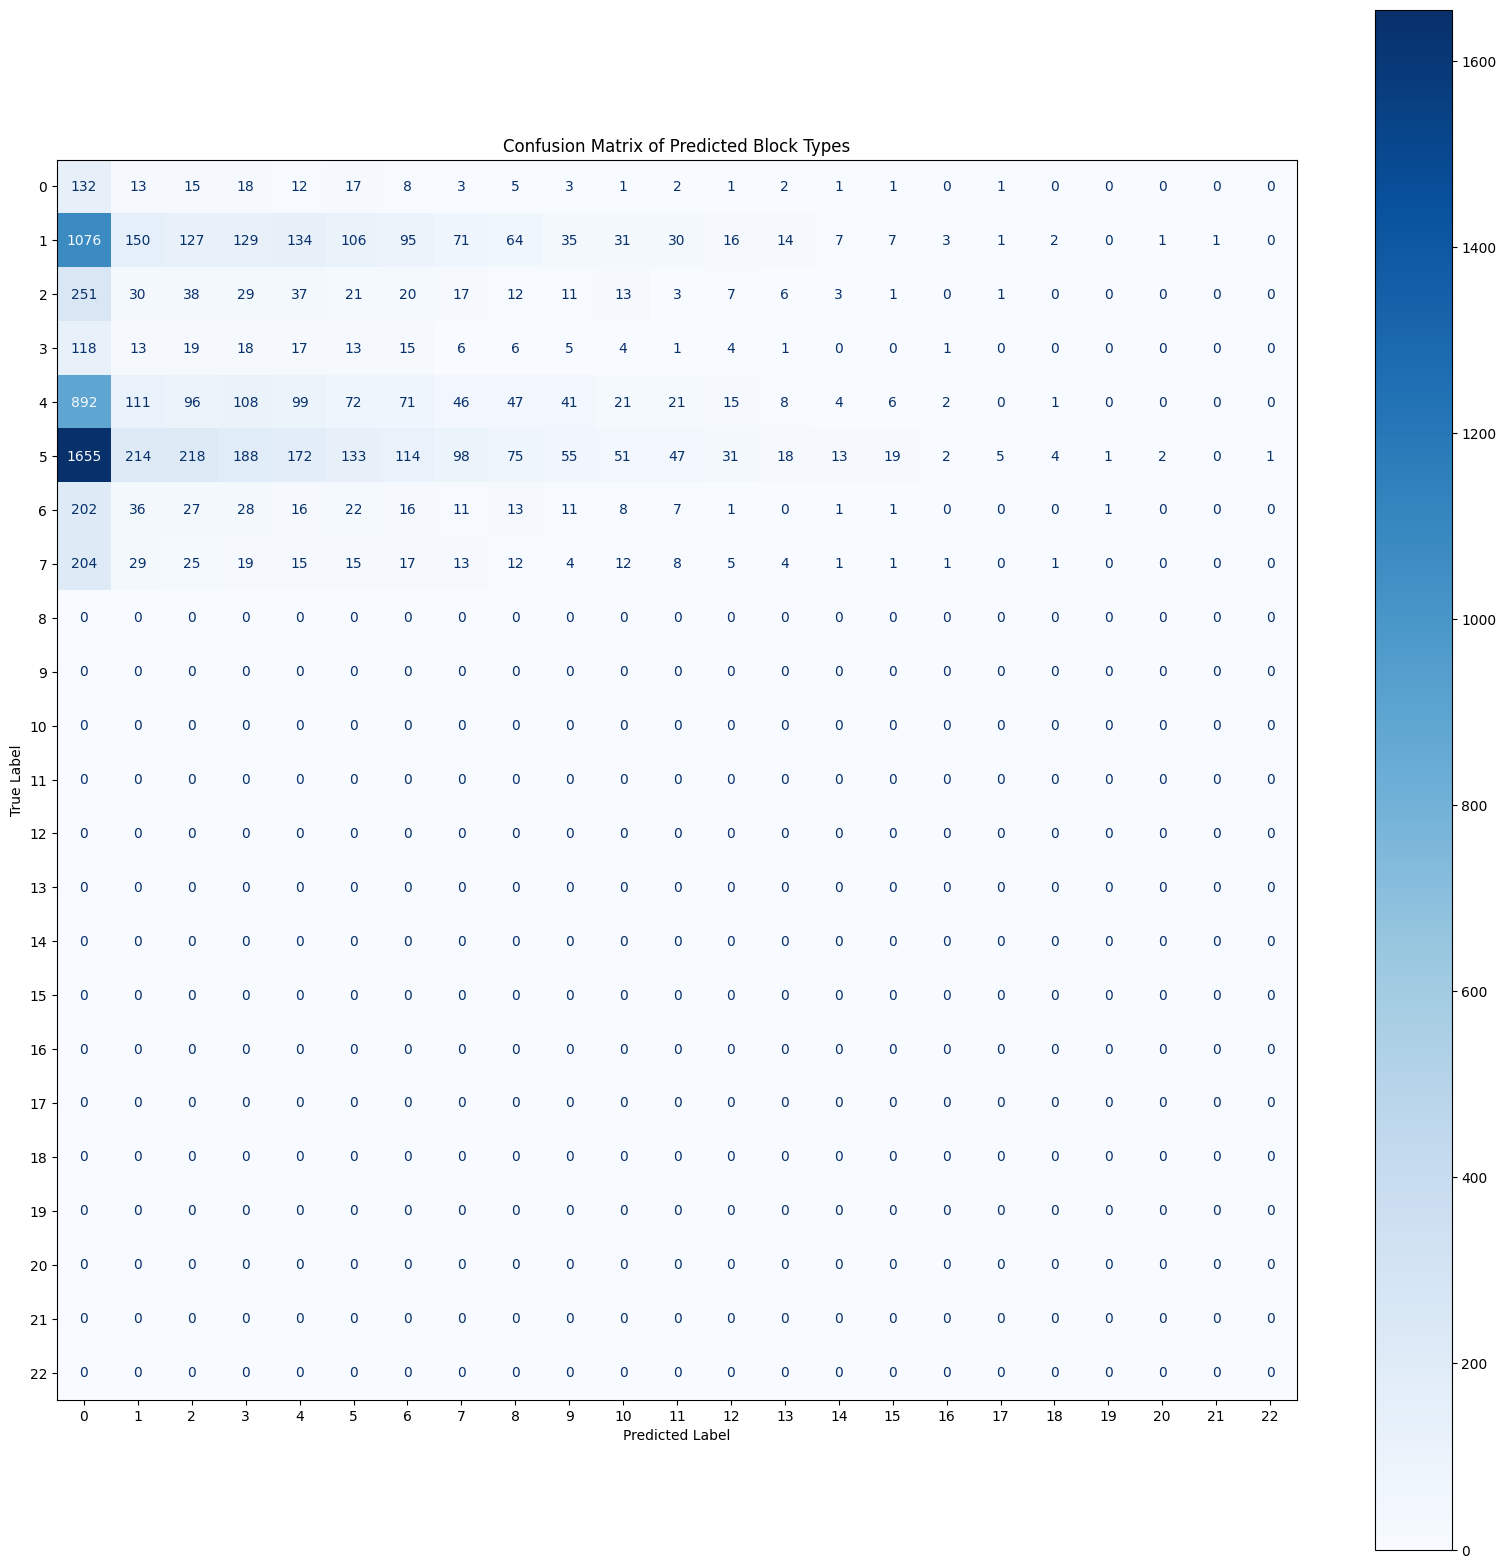

In [109]:
## Confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Build confusion matrix
cm = confusion_matrix(y_true_valid, y_pred_valid)

# Plot
fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title('Confusion Matrix of Predicted Block Types')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()